# understanding splines and bezier curves first

In [2]:
#only numpy implementation

import numpy as np
import matplotlib.pyplot as plt

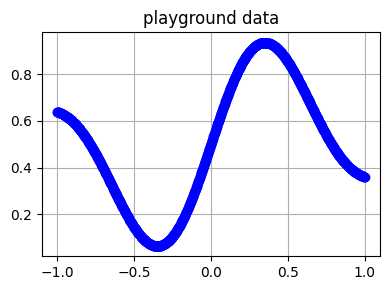

In [6]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-1, 1, 1000)
y = .5 * np.sin(4*x) * np.exp(-x**2) + .5

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x, y, 'o', color='b')
ax.set_title("playground data")
ax.grid()
fig.tight_layout()

In [47]:
grid = np.linspace(-1, 1, 10)
print(f"grid shape {grid.shape}, values: {grid}")
print(f"x shape {x.shape}, values: {x[:5]}")

grid shape (10,), values: [-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]
x shape (1000,), values: [-1.         -0.997998   -0.995996   -0.99399399 -0.99199199]


General higher order basis function formula (Cox-de Boor recursion) $$ N_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} N_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(x) $$

In [12]:
grid_ = grid.reshape(1, -1)
x_ = x.reshape(-1, 1)
print(f"grid shape {grid_.shape}, values: {grid_}")
print(f"x shape {x_.shape}, values: {x_[:5]}")

grid shape (1, 10), values: [[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
   0.33333333  0.55555556  0.77777778  1.        ]]
x shape (1000, 1), values: [[-1.        ]
 [-0.997998  ]
 [-0.995996  ]
 [-0.99399399]
 [-0.99199199]]


In [16]:
# recursive spline formulation

# order 0, piecewise constant function
k = 0
value1 = (x_ >= grid_[:,:-1]) * (x_ < grid_[:, 1:]) #base case, if 1 if  x  lies within the interval [t_i, t_{i+1}) and 0 otherwise.

k = 1 # order 1
value21 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value1[:, :-1]
value22 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value1[:, 1:]
value2 = value21 + value22

k = 2 # order 2
value31 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value2[:, :-1]
value32 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value2[:, 1:]
value3 = value31 + value32

k = 3 # order 3
value41 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value3[:, :-1]
value42 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value3[:, 1:]
value4 = value41 + value42

In [17]:
print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")

k=0, number of basis functions: 9
k=1, number of basis functions: 8
k=2, number of basis functions: 7
k=3, number of basis functions: 6


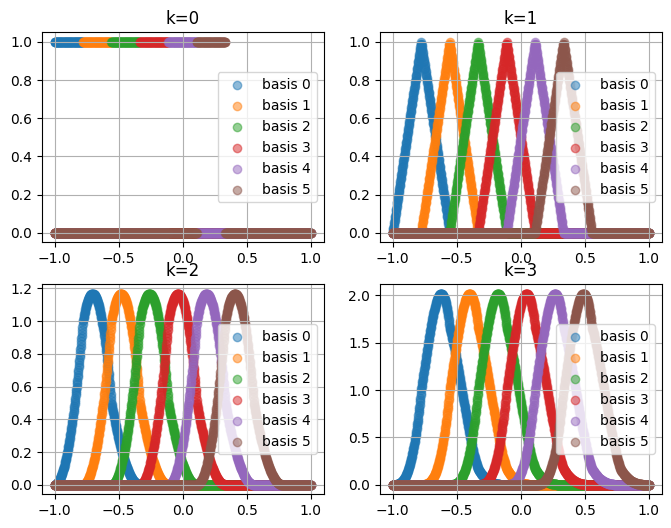

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), dpi=100)
n_plot = 6
basis_funcs = [(value1, "k=0"), (value2, "k=1"), (value3, "k=2"), (value4, "k=3")]
for i, (basis, label) in enumerate(basis_funcs):
    ax = axs[i//2, i%2]
    for idx in range(basis.shape[-1])[:n_plot]:
        ax.scatter(x_, basis[:, idx], label=f"basis {idx}", alpha=0.5)
    ax.set_title(label)
    ax.grid()
    ax.legend()

In [51]:
grid_.shape, np.array([0]*len(grid_)).shape

((1, 10), (1,))

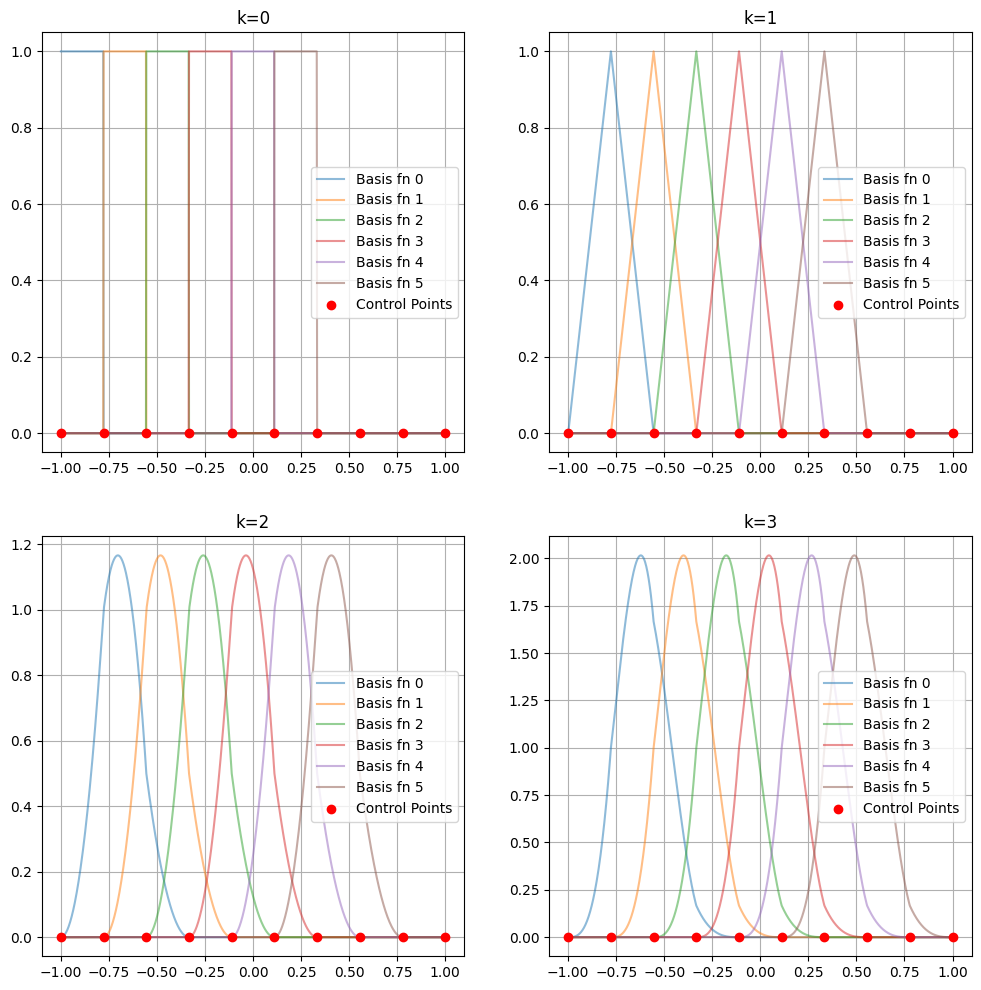

In [53]:
# x axis doesn't lie with control points thats why below figure is not correct
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12), dpi=100)

for i in range(4):
    ax = axs[i // 2, i % 2]
    value, label = basis_funcs[i]
    
    # Plot the basis functions
    for idx in range(value.shape[-1])[:n_plot]:
        ax.plot(x, value[:, idx], label=f"Basis fn {idx}", alpha=0.5)
    
    # Plot the control points
    # ax.scatter(grid_, [0] * len(grid), color='red', zorder=5, label='Control Points')
    ax.grid()
    ax.set_title(label)
    ax.legend()

plt.show()

## Analysis of Basis Functions

- **Step Basis Functions**: This case involves one-hot encoded vectors.
- **Piecewise Linear Basis Functions**: This case utilizes linear functions.
- **Non-linear Basis Functions**: This case involves non-linear functions.
in plotting k=2 and k=3 looks almost same but they are not k=3 cubic interpolation

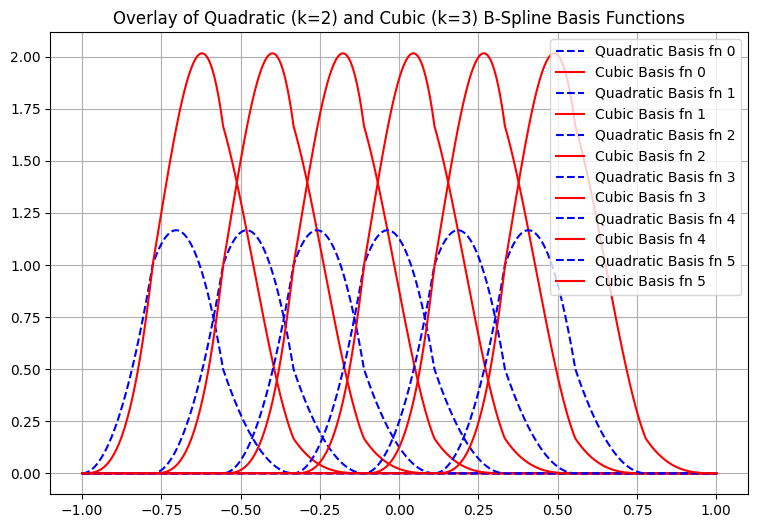

In [27]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=100)

for idx in range(value3.shape[-1])[:n_plot]:
    ax.plot(x, value3[:, idx], label=f"Quadratic Basis fn {idx}", color='b', linestyle='--')
    ax.plot(x, value4[:, idx], label=f"Cubic Basis fn {idx}", color='r', linestyle='-')

ax.grid()
ax.set_title('Overlay of Quadratic (k=2) and Cubic (k=3) B-Spline Basis Functions')
ax.legend()

plt.show()

In [25]:
import collections

value3_counts = collections.Counter(np.where(value3 !=0)[0].tolist())
value_4_counts = collections.Counter(np.where(value4 !=0)[0].tolist())
print('min non-zero basis functions for k=2:', min(value3_counts.values()))
print('max non-zero basis functions for k=2:', max(value3_counts.values()))
print('min non-zero basis functions for k=3:', min(value_4_counts.values()))
print('max non-zero basis functions for k=3:', max(value_4_counts.values()))


min non-zero basis functions for k=2: 1
max non-zero basis functions for k=2: 3
min non-zero basis functions for k=3: 1
max non-zero basis functions for k=3: 4


extending grid to ensure that all features within the input domain have an equal number of non-zero basis functions.



In [16]:
grid = np.linspace(-1, 1, 5, dtype=np.float32)
print('olg grid:', grid, grid.shape)
k  = 2
n_intervals = grid.shape[0] - 1
bucket_size = (grid[-1] - grid[0]) / n_intervals
#extend grid
for i in range(k):
    grid = np.concatenate([grid[:1] - bucket_size, grid], axis=0, dtype=np.float32)
    grid = np.concatenate([grid, grid[-1:] + bucket_size], axis=0, dtype=np.float32)
print('new grid:', grid, grid.shape)

olg grid: [-1.  -0.5  0.   0.5  1. ] (5,)
new grid: [-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ] (9,)


In [17]:
def extend_grid(grid, k):
    """
    Extends the grid by k steps
    
    Returns:
    --------new_grid: n_control_pionts + 2 * k
    """
    n_intervals = grid.shape[-1] - 1
    bucket_size = (grid[:, -1] - grid[:, 0]) / n_intervals
    for i in range(k):
        grid = np.concatenate([grid[:, :1] - bucket_size, grid], axis=1)
        grid = np.concatenate([grid, grid[:, -1:] + bucket_size], axis=1)
    return grid

In [20]:
def eval_(x_eval, grid, k):
    grid_ = extend_grid(grid, k)
    print(f"grid shape {grid_.shape}")
    grid_ = np.expand_dims(grid_, axis=2)
    print(f"grid shape after expand {grid_.shape}")
    x_ = np.expand_dims(x_eval, axis=1)
    print(f"x_ shape {x_.shape}, x_eval {x_eval.shape}")
    for idx in range(k+1):
        if idx == 0:
            print(f"x_ shape {x_.shape}, grid_ shape {grid_.shape}")
            bases = (x_ >= grid_[:, :-1]) * (x_ < grid_[:, 1:]) * 1.0 # step function; for each x in between the corresponding knots, the value is 1.
        else:
            bases1 = (x_ - grid_[:, :-(idx+1)]) / (grid_[:, 1:-idx] - grid_[:, :-(idx+1)]) * bases[:, :-1]
            bases2 = (grid_[:, (idx+1):] - x_) / (grid_[:, (idx+1):] - grid_[:, 1:-idx]) * bases[:, 1:]
            bases = bases1 + bases2

    return bases.transpose(0,2,1) * 1.0


In [21]:
grid = np.linspace(-1, 1, 10, dtype=np.float32)
x = np.linspace(-1, 1, 1000, dtype=np.float32)
print(f"Grid: Shape:{grid.shape}, values:", grid)
print(f"x: Shape:{x.shape}, values:", x[:5])
grid_ = np.expand_dims(grid, axis=0)
x_ = np.expand_dims(x, axis=1)
value1 = eval_(x_, grid_, k=0)
value2 = eval_(x_, grid_, k=1)
value3 = eval_(x_, grid_, k=2)
value4 = eval_(x_, grid_, k=3)
print(value1.shape)
print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")



Grid: Shape:(10,), values: [-1.         -0.7777778  -0.5555556  -0.33333334 -0.11111111  0.11111111
  0.33333334  0.5555556   0.7777778   1.        ]
x: Shape:(1000,), values: [-1.       -0.997998 -0.995996 -0.993994 -0.991992]
grid shape (1, 10)
grid shape after expand (1, 10, 1)
x_ shape (1000, 1, 1), x_eval (1000, 1)
x_ shape (1000, 1, 1), grid_ shape (1, 10, 1)
grid shape (1, 12)
grid shape after expand (1, 12, 1)
x_ shape (1000, 1, 1), x_eval (1000, 1)
x_ shape (1000, 1, 1), grid_ shape (1, 12, 1)
grid shape (1, 14)
grid shape after expand (1, 14, 1)
x_ shape (1000, 1, 1), x_eval (1000, 1)
x_ shape (1000, 1, 1), grid_ shape (1, 14, 1)
grid shape (1, 16)
grid shape after expand (1, 16, 1)
x_ shape (1000, 1, 1), x_eval (1000, 1)
x_ shape (1000, 1, 1), grid_ shape (1, 16, 1)
(1000, 1, 9)
k=0, number of basis functions: 9
k=1, number of basis functions: 10
k=2, number of basis functions: 11
k=3, number of basis functions: 12


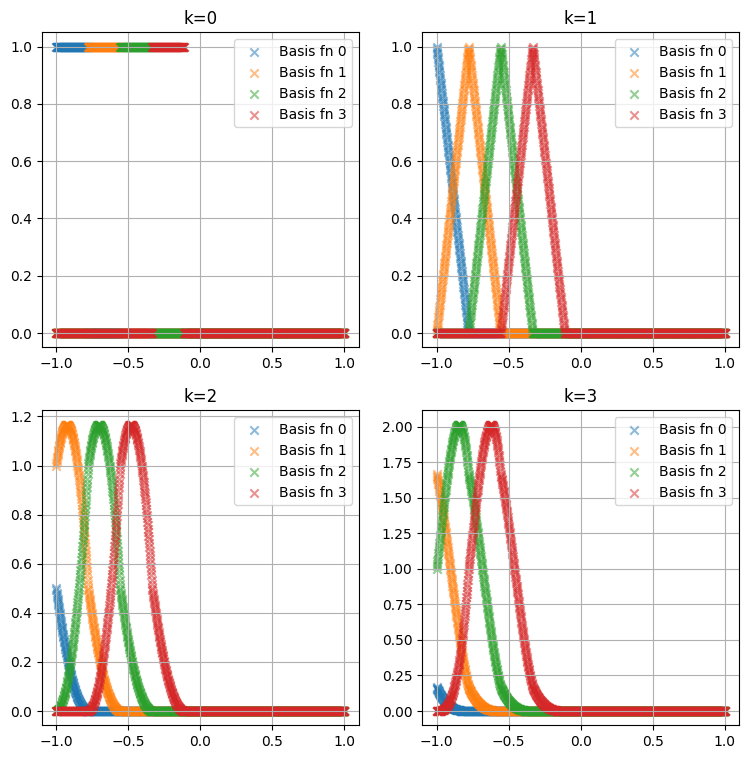

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 9), dpi=100)

n_basis_to_plot = 4
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]
for i in range(4):
    
    ax = axs[i // 2, i % 2] 

    value, label = all_basis[i]
    for idx in range(value.shape[-1])[:n_basis_to_plot]:
        ax.scatter(x_, value[:, 0, idx], marker='x', label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

boundary points get the same number of non-zero basis functions.